# 01 - BIOINFORMATICS - De Novo Assembly Method To Obtain The gene sequence.

## Project Description

Data is in _fasta_ format. Every two lines represents a read (a DNA fragment) with 60bp. The first line started with ‘>’ contains the name of the read and the second line is the nucleotide sequence. 

Tips: 
- Repeated sequences larger than 25bp do not occur in original sequence. 
- Each read overlaps at least 25bp with other reads.


## Project objective
These reads (DNA fragments) of repeated sequences overlap. The task is to construct a de novo method to assemble these reads and obtain the gene sequence.

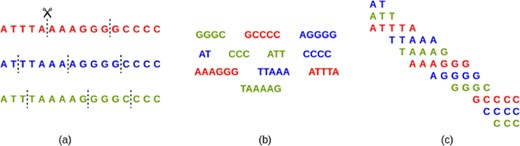

* bp = A base pair (bp) is a fundamental unit of double-stranded nucleic acids consisting of two nucleobases bound to each other by hydrogen bonds. They form the building blocks of the DNA double helix and contribute to the folded structure of both DNA and RNA.

## Project Methodology
De novo genome assembly relies on two kinds of graphs: de Bruijn graphs and overlap graphs. Overlap graphs are the basis for the Celera assembler, while de Bruijn graphs have become the dominant technical device in the last decade. Those two kinds of graphs are collectively called assembly graphs.

https://link.springer.com/content/pdf/10.1007/s40484-019-0181-x.pdf

# Overlap Graphs (Overlap-Layout-Consensus)
![Screen%20Shot%202022-12-10%20at%209.21.37%20PM.png](attachment:Screen%20Shot%202022-12-10%20at%209.21.37%20PM.png)

## 1) Directed Graph (DG): Oriented Fragments Based
In this graph paradigm there are two vertices for each read, one for the forward orientation, and one for the reverse orientation. Each overlap (r, q) in the overlaps set O is associated with an oriented edge from r to q. Moreover, (r, q) ∈ O ⇐⇒ (q, r) ∈ O (and hence there exists an edge from q to r). As a consequence, this
paradigm is defined as an oriented fragments based one, because each vertex represents a read for a fixed orientation.

## 2) Bi-directed Graph (BG): Oriented Walk Based
The key idea is to represent each read with only one vertex and to keep the strict necessary overlap information
between two reads on the edge connecting two vertices.

This paradigm is defined as an oriented walk graph based. Indeed, given a vertex enriched by an orientation value, it is necessary to verify for each of its oriented neighbours if they are the successors or predecessors (determined by reluv). Also, the reluv attribute depends on the vertex with the smaller identifier.

## 3) Undirected Graph (UG): Tail-Head Fragments Based
Both the tail and the head are vertices, and there is one edge from the tail to the head. Passing through the tail first and then the head corresponds to choose the read in forward orientation, while traversing the head first and then the tail corresponds to choose it in its reverse orientation. This new type of edges are called read-edges, at the opposite of overlap-edges that correspond to overlaps. A valid walk in this graph must alternate between read-edges and overlap-edges, starting from and finishing by a read-edge

### Notes

De novo sequencing refers to sequencing a novel genome where there is no reference sequence available for alignment. Sequence reads are assembled as contigs, and the coverage quality of de novo sequence data depends on the size and continuity of the contigs (ie, the number of gaps in the data).

In [1]:
import itertools

import networkx as nx
import os

from collections import Counter
from overlap import get_overlap_graph, hamilton, get_start, get_contig
from itertools import permutations

import matplotlib.pyplot as plt

import debruijn as db

# 1 Read and preprocess the dataset

## 1.1 Read the data

In [2]:
def readGenome(file):
    genome = ''
    with open(file, 'r') as f:
        for line in f:
            """ If the 1st character of the line is not an error, then we add the line to genome string
            """
            if not line[0] == '>':
                genome += line.rstrip()

    return genome

In [3]:
genome = readGenome('20Xreads.fasta')
print(genome[:100])

GGATTGCTTTCAGCACTCGCAGCCGTGGACCGCCGTGCGGTCCTTTCCTCCGCAGTGAGCGAAGAATCAATCTGTGTGAGTCTGTTTTTCAAAATGAAAT


Let's check the length of the genome to make sure all the dataset is loaded.

In [4]:
len(genome)

316919

## 1.2 Data analysis

### 1.2.1 Read the file

In [5]:
def readFasta(file):
    sequences = []
    qualities = []
    with open(file) as fh:
        while True:
            fh.readline()
            seq = fh.readline().rstrip()
            fh.readline()
            qual = fh.readline().rstrip()
            if len(seq) == 0:
                break
            sequences.append(seq)
            qualities.append(qual)
    return sequences, qualities

In [6]:
seqs, quals = readFasta('20Xreads.fasta')

In [7]:
seqs[5:]

['AGACGGTCACCATGATCCTGTCTGCGGTCCACATCCAACCTTTTGACATTATCTCAGATT',
 'TTTTAAGTCGTTGTTTATAGTTGCCTATGGCCTGAGAAATCAAACCTCATAGATTTTTAG',
 'GAAAGAGCGTCAAACCCTTTCTCTATCTTGCCCTGCCAAACAACAGGAGAAGCACAGCCA',
 'CGGTGAAACATGTGAAACGTCATACTAAGTAGGATGACTGAAAACTACAAGCAGCCTCAC',
 'ACATTAGGTTAGGAACAATGAGGGTTCTAACTATTGCTCTGGGCTCTTGCTGTAGCTGGG',
 'ATGGAAGCATTTACAAAATGTAACAGTCAGTGTCTCTCTTAAACTGAAAATATTAAGCAT',
 'GATATAAGAACATTTTCTGCCACACTGAAACTTTCAGTCTAGTGGGATAGGGTGTATACA',
 'CTTGAGATAAAAAATATGGCCCTTAATGTTTTGCGGTGTTTTTTCTTTTTTTCTTTTAGG',
 'CTATAGAGAGTTTGAAGGATTAAAGGCACAATAAGCTTCATTGGGTGACAGTTGGAAAGG',
 'TGTGTGGGCCAGCAACTACGTAGATGTAAGGAATCTTTCCCCCCCCTCAGCTTGCTCCTA',
 'CCTCAAGGTTTTGGAAACCGTCCCACGCTTTGAGGTCCCAGGCCAAGTCTTCCCTCGGCT',
 'AGTGCAGGATTTGGTAGTAGCTATGATACTTTTTGACATCTTCATAGTTGATATCCTCTT',
 'ATCATGGCCAACATATATGTGTTCCAATAAGGAAATACATATATTGCTGTATCTGAAATT',
 'AGCTGGCTTATCCTATACAGTTGTCAATGCACACAGAATACAACCTCATGCTCCCTGCAG',
 'TCTAGGCCTGCCACTCTTTCTGATACACTGTGTCATCTCAGGTCCTGTCCCTGGAGCAAT',
 'GTTTTACCTGCTCTTGAACTTCA

In [8]:
quals[5:]

['TTTCAAGGAGTATGCAAAGCAGGCAGGCTCCATACAGCTGCAAATTTTCTTGTTTAAGCT',
 'CAACAAGGGTGTTACAAGTTCCTGTCATTCCACATCATCACCAACACTTGGTATTTTCAG',
 'GAGTCCTAGCTAGGCGCTCACAGAATACGCGCTCCCTCCCTCCCCCTTCTCTGTCCCCCG',
 'TAGGGTGACTATAGTTAACAACCATGTGTTGTACATTTCAAAATAGCCAGAAGTGAGGAC',
 'TTGTTGACATCTGCCAGGAATCCAATAATTACATGTTGTCCTAGTTAATTGATGTATTTT',
 'CAGTCTTTTTGAAACTTACATATTTTTATATAATGCGTTATGTGTACATATTACTTTAAT',
 'CTGCAATCTGTGTTAACATTACATGGGCAACAGAGTGTTATCATGAGGAAAATAAATAAC',
 'TTCCTCCGCAGTGAGCCGATTTGCTCTGCCAGCAGCTGTCGGTGCCGCGCTCGACACCGA',
 'TGAGATGTTCATTTGTAAAAATTCATCAAGCTCTACACTTACTTAAAAATTATAGCATAA',
 'GCCTGGAGTAAGCTACTGGGCTCAAGAGATTCTCCCACCCCAGTTTCCCCAGTAGCTGGG',
 'ACCATGGAAGAGTCAGGGCAGCCCCATGCAATCAAACATATTAATATATCTGTTTCCTGC',
 'AGCGTTCATCCCCCAAATAACAATATTCCTATCTGCAGACACCGTCAAAGACCACATTTA',
 'TTAAAAATGAATCAACAATAAAAACAATGATGATTGTGTCTAATGGTGAAACTCTGAACA',
 'TTCTGTGGCCTTTTAATGCCAGTAGTTTAGGTCTGTTAAGTGCTGCCCCAACTATAGTGT',
 'CAATAAAAAATAACAAAGTAATCAACAAATCTAAAATGTATGGTTTAATGCTTTCGTACT',
 'TACTGGGCTCAAGAGATTCTCCC

### 1.2.2 Frequancy analysis of each base

In [9]:
counts = {'A' : 0,
          'C': 0,
          'G' : 0,
          'T': 0}

In [10]:
for base in genome:
    counts[base] += 1
print(counts)

{'A': 87414, 'C': 65567, 'G': 68836, 'T': 95102}


Let's do sequences analysis through ***collections*** Python module.

In [11]:
Counter(genome)

Counter({'G': 68836, 'A': 87414, 'T': 95102, 'C': 65567})

### ***Conclusion:*** The 'T' genes are the most frequent, while the gene 'C' is the least frequent.

### 1.2.3 Histograms of a quality score

#### 1.2.3.1 Create a function for converting the symbols to the score

In [12]:
def phred33ToQ(qual):
    return ord(qual) - 33

In [13]:
phred33ToQ('#')

2

##### ***Conclusion:*** A low quality score '#' says we have a very low confidence of our value.

In [14]:
phred33ToQ('J')

41

##### ***Conclusion:*** The score 41 for 'J' is a very high confidence.

#### 1.2.3.2 Create a function for building a histogram.

In [15]:
def createHist(sequences):
    hist = [0] * 70

    for seqs in sequences:
        for  phred in seqs:
            s = phred33ToQ(phred)
            hist[s] += 1
    return hist

In [16]:
s_hist = createHist(seqs)
print(s_hist)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 43465, 0, 32867, 0, 0, 0, 34800, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 47328, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [17]:
def createHist(qualities):
    hist = [0] * 70

    for qual in qualities:
        for  phred in qual:
            q = phred33ToQ(phred)
            hist[q] += 1
    return hist

In [18]:
q_hist = createHist(quals)
print(q_hist)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 43949, 0, 32700, 0, 0, 0, 34036, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 47774, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


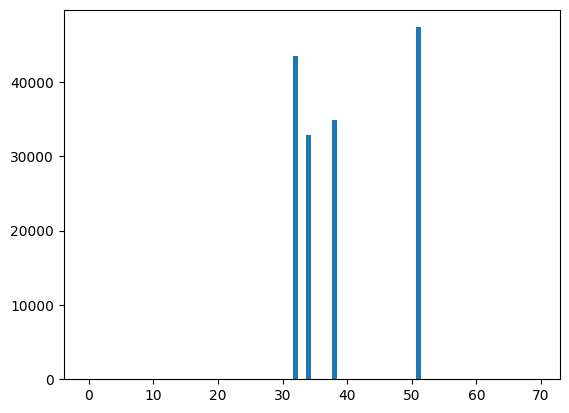

In [19]:
%matplotlib inline

plt.bar(range(len(s_hist)), s_hist)
plt.show()

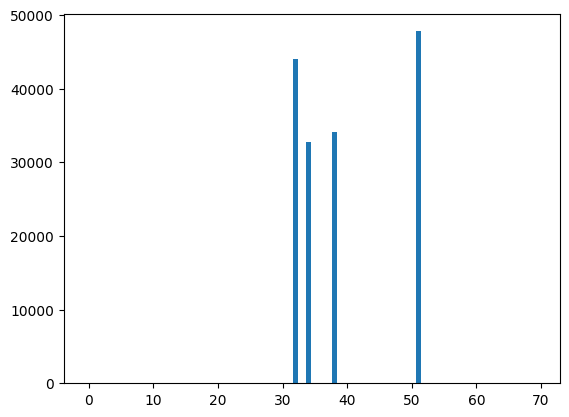

In [20]:
%matplotlib inline

plt.bar(range(len(q_hist)), q_hist)
plt.show()

### 1.2.4 Analyzing reads by position

In [21]:
def findGCByPos(reads):
    gc = [0] * 100
    totals = [0] * 100

    for read in reads:
        for i in range(len(read)):
            if read[i] == 'C' or read[i] == 'G':
                gc[i] += 1
                totals[i] += 1
        for i in range(len(gc)):
            if totals[i] > 0:
                gc[i] /= float(totals[i])
        return gc

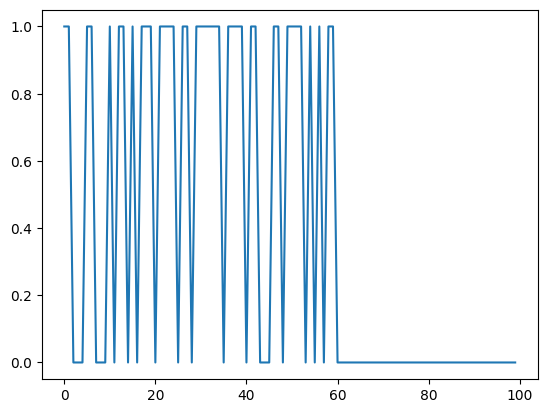

In [22]:
gc = findGCByPos((seqs))
plt.plot(range(len(gc)), gc)
plt.show()

### 1.2.5 Distribution of nucleotides in the sequences

In [23]:
count = Counter()
for seq in seqs:
    count.update(seq)
print(count)


Counter({'T': 47328, 'A': 43465, 'G': 34800, 'C': 32867})


# 2 Construct a Graph for DNA Sequencing

## 2.1 Overlap Graph

In [24]:
data_string = db.read_reads(os.getcwd() + '/20Xreads.fasta')

In [49]:
full_str = ''
for read in data_string:
    full_str += read

full_str

'GGATTGCTTTCAGCACTCGCAGCCGTGGACCGCCGTGCGGTCCTTTCCTCCGCAGTGAGCGAAGAATCAATCTGTGTGAGTCTGTTTTTCAAAATGAAATAAAACACACTATTCTCTGGCTAACATTTATGCTTCTCACTGCTTTATAATCATGGCCAACATATATGTGTTCCAATAAGGGCGCCTGCAAACCAATCAAACCCTGCAATCTGTGTTAACATTACATGGGCAACAGAGTGTCTCCCACCTTGACCTCTGAAAGTTTTGGGATTACAGGCAGGATCCACCATGCCCAGCCTAAAACATGTGAAACGTCATACTAAGTAGGATGACTGAAAACTACAAGCAGCCTCACATTAGAGCGAAGGAATGAGGCTTGTTAGACCCGGGTTAGAGAAACGGCTCGTAGAGCGCACAGCTGAATGGGATGTGAGACATTCTTTTTTATTATCAATTTAGAAATAATACTTTTGGTACTTGTGCGAGTATGGATCTCCAAGGAAGAGGGGTCCCCAGCATCGACAGACTTCGAGTTCTCCTTTTCTGAAAAATAGTCCCAAAGCTTCCTTGAGAAATCTTTTTACCTCCATTTCCCTTTTTAGACGGTCACCATGATCCTGTCTGCGGTCCACATCCAACCTTTTGACATTATCTCAGATTTTTCAAGGAGTATGCAAAGCAGGCAGGCTCCATACAGCTGCAAATTTTCTTGTTTAAGCTTTTTAAGTCGTTGTTTATAGTTGCCTATGGCCTGAGAAATCAAACCTCATAGATTTTTAGCAACAAGGGTGTTACAAGTTCCTGTCATTCCACATCATCACCAACACTTGGTATTTTCAGGAAAGAGCGTCAAACCCTTTCTCTATCTTGCCCTGCCAAACAACAGGAGAAGCACAGCCAGAGTCCTAGCTAGGCGCTCACAGAATACGCGCTCCCTCCCTCCCCCTTCTCTGTCCCCCGCGGTGAAACATGTGAAACGTCATACTAAGTAGGATGACT

In [25]:
overlap_graph = get_overlap_graph(data_string, 3)

In [26]:
hamilton_path = hamilton(overlap_graph, get_start(overlap_graph))

In [56]:
# DNA sequence
dna_seq = get_contig(hamilton_path, 3)
print('DNA sequence: {0}'.format(dna_seq))

DNA sequence: ACGTGATCCATTTCTATTCATTGTTCTCTTTAAAGAGGCAATATGGTATCATACTGGCGACTCCTCGGAGAAAACCCACTTCAAAGACGCAGTCAGTGGTGAGTGGAGGCTGGCATGGTGTCCCCAGGCTTACGCCTTGACATTCCTGGGAGGTGGCAAGCCTCATTCAGAATCGACTGCAGCTACCTGACAGTGGATTCTGCACCATGTATAATTTACTAGCGTTTCTGGGTACTCTTAATAGTTTATGACTTTCTAGTTTTTGCTGATTAGCTGTTACTAGGCGCTGGGACTACAGGCATGTGTCACCATGCCAGACTAATTTTGTAAATGTATGTGTGTGTGAAGGTAAGTTGTTGGGGGATGGAGGGGAAGAAGACCTAGTTTATTTCAGGAAGGATGGTGTCCCCAGGCTTACGCCTTGACATTCCTGGGAGGTGGCAAGCCTCATTCAGAATCGACTGCAGCTACCTGACAGTGGATTCTGCACCATGTATAATTTACTAGCGTTTCTGGGTACTCTTAATAGTTTATGACTTTCTAGTTTTTGCTGATTAGCTGTTACTAGGCGCTGGGACTACAGGCATGTGTCACCATGCCAGACTAATTTTGTAAATGTATGTGTGTGTGAAGGTAAGTTGTTGGGGGATGGAGGGGAAGAAGACCTAGTTTATTTCAGGAAGGATGGTGTCCCCAGGCTTACGCCTTGACATTCCTGGGAGGTGGCAAGCCTCATTCAGAATCGACTGCAGCTACCTGACAGTGGATTCTGCACCATGTATAATTTACTAGCGTTTCTGGGTACTCTTAATAGTTTATGACTTTCTAGTTTTTGCTGATTAGCTGTTACTAGGCGCTGGGACTACAGGCATGTGTCACCATGCCAGACTAATTTTGTAAATGTATGTGTGTGTGAAGGTAAGTTGTTGGGGGATGGAGGGGAAGAAGACCTAGTTTATTTCAGGAAGGATGGTGTCCCCAGGCTT

## 2.2 De Bruijn Graph

In [27]:
def dr_bruijn_ize(st, k):
    edges = []
    nodes = set()
    for i in range(len(st) - k + 1):
        edges.append((st[i:i+k-1], st[i+1:i+k]))
        nodes.add(st[i+1:i+k])
        nodes.add(st[i+1:i+k])
    return nodes, edges

In [28]:
nodes, edges = dr_bruijn_ize(genome, 13)

In [29]:
print(nodes)

{'TAAAGCAAGGGG', 'ATGCAAGATGTC', 'ATCTAAGAGCAA', 'TGGCAGGTTCAT', 'TGATTGGGGGTG', 'GCTATGATATGC', 'CTGAAGGTACAC', 'ATTAAGTAAGAA', 'GTGGAATCAAAT', 'ACTTTAGTGGCG', 'CAAATAGAGGCC', 'ATTTTCTTGTCA', 'TCTCAGGGCTCT', 'AAAGCTGCTCCT', 'TTTTCTTAGTGA', 'TCATCTTAAAAA', 'TCAACATGTGAT', 'GGCCCATGGAAA', 'AGCAACTATCAC', 'TCTTTCCCTTTT', 'TGCTCCTAGGGC', 'TAGTTTTGCCAT', 'GGAAGGGGGATA', 'ATCAGAAAAAAA', 'GACCCCCAACTG', 'CATAAATTATTA', 'AGATATAAGCAT', 'TCATACTGGCGT', 'ACCGCCATATCT', 'AAATGTATGGTT', 'AAAATAACAAAG', 'ATCCAGAAAACG', 'CGTTCAACAGAT', 'GTTTCTGAGGTC', 'AAGAAGTCCCTT', 'ATGTCTATTCAT', 'GCGGGAGCAACT', 'TGTCAAGCTTCA', 'CAGAAACATATA', 'GGCGTGATCCAT', 'TGAGAAGGGAGA', 'ATGACCCCTTGG', 'ATATTACAAACA', 'ACCCAGGCATGA', 'TTTTTCAAAATG', 'TTCAGATAAATT', 'GTAGATCGCGCA', 'ATTAGGTTAGGA', 'ATATTTAATGTC', 'CCTCCTGCTTTT', 'TGAACTTCATAT', 'CCCCAGAGCTTG', 'CAAGAAATATTC', 'TTTACTAGCGTT', 'CTACAGTCACCC', 'GACAGAAAAGTT', 'GTGAGATGTTCA', 'CTGTTCTAGTTT', 'AGCTAGGCTCGC', 'GCCTCTGCAAAT', 'TTCAAAAAAGGA', 'AAAGGAGTCTAA', 'GAGAAG

The length is often denoted by k, and sequences k-mers. The value of k is important for constructing de Bruijn graph. A large value of k will remove some short repetitive regions while reducing the number of nodes in de Bruijn graph, but will give rise to more unconnected sub-graphs which means that the number of gap regions increases. A small value of k will reduce some gap regions while increases the connectivity of de Bruijn graph, but will add more nodes and increase short repetitive regions. **. Therefore, the value of k cannot be too large or too small.**

In [57]:
file = db.read_reads('/Users/yuliabezginova/PycharmProjects/01_BIO_DeNovoAssembly/20Xreads.fasta')

In [60]:
# Construct de bruijn graph from sets of short reads with k length word
bruijn_graph = db.construct_graph(file, 5)

In [61]:
type(bruijn_graph)

tuple

In [62]:
# Perform searching for Eulerian path in the graph to output genome assembly
path = db.output_contigs(bruijn_graph)

In [69]:
print('De Bruijn Graph: ')
path

De Bruijn Graph: 


'TGCCGCGCTCACTGCTTTCAGCACTCGCAGCCGTGGACCGCCGTGCGGTCCTTTCCTCCGCAGTGAGCCGATTTTCAAAATGAAATAAAACACACTATTCTCTGGCTTGTTAACATTTATGCTTCTCACATTACATGGCCAACATATATGTGTGAGTCTGTGTTCCAATAAGGAATGAGGCTTATCAATCTGTTTTTCTGAAAGTTTTGGGATTGCTTTATAATCAAACCAATCATGGGCAACAGAGTGTCTGCGGTCACCATGCCCAGCCTATGGATCCACCTTGACCTCTGAAACGTCATACTAAGTAGGATCTCCAAGGAAGAATCAATTTAGACCCGGGTTAGAGAAACGGCTCGTAGAGCGCACAGCTGCAAACCCTGCAATCTGTGTTAGAAATAATACTTTTTTATTATCTCAGATTTGCGGTGAAAACTACAAGCAGCCTCACAGCTGGGCTCCATTTCCCTTTTGGTACTTGGTATTTTTACCTCCATACAGGCAGGATGACTGAAAAATAGTCCCCAGCATCGACAGACTTCGAGTATGGCCTGCAAAGCTTCCTTGAGACATTAGGTTAGGATGTGAAACATTCTTTTTAAGCTTCATTCCACATCCAACCTTTTTGACATTATCATCATGATCCTGTCTCTATCTTTTGAAACGTCAAACCTCATAGATTCTCCTAGCTAGGCGCTCCCACCATGAGGACCGCCGTGGAGTATGCAAATTTTCAAGGAGTAAGGATTACAGCCAGAATACGCGCTCGACACCGAATGGGATGACTGAAAACTACAAGGGTGTTACAAGTTCTCTGTCATTGGGTGACTATAGTTGCCTAGTTAACATGTGAGAAATCTTGTTTAAGTCGTTGTTTATAGTTAATTACATTTCAGTGTTGTACATGTGAAAATAGCCACATCACCAACAAGCAGGCAGGCTCTGGGCAACACTTGAGAAATCAAACCCTTTCTTGCCCTGCCAAAGCACAGAAGCAGC

In [64]:
# Print the information in the graph to be (somewhat) presentable
# db.print_graph(bruijn_graph)

In [65]:
class GraphVisualization:

    def __init__(self):
        self.visual = []
        self.G = nx.DiGraph()

    def addEdge(self, a, b):
        temp = [a, b]
        self.visual.append(temp)

    def visualize(self):
#         options = {
#             'node_color': 'blue',
#             'node_size': 50,
#             'width': 1,
#             'arrowstyle': '-|>',
#             'arrowsize': 10,
#         }
#         self.G.add_edges_from(self.visual)
#         pos = nx.spring_layout(self.G, seed=15000)
#         nx.draw(self.G, pos, with_labels=False, **options)
#         plt.show()

        options = {
            'node_color': 'blue',
            'node_size': 50,
            'width': 1,
            'arrowstyle': '-|>',
            "linewidths": 1
        }
        G = nx.Graph()
        G.add_edges_from(self.visual)
        pos = nx.circular_layout(G)
        nx.draw_networkx(G, pos, with_labels=False, **options)
        plt.show()

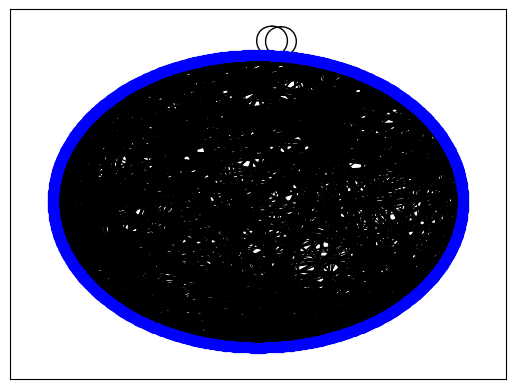

In [66]:
graph_plot = GraphVisualization()

vertexes = bruijn_graph[0] # take the nodes
edges = bruijn_graph[1]

for vertex in vertexes.keys():
    edges1 = edges[vertex]
    for edge in edges1:
        graph_plot.addEdge(vertex, edge.label)
graph_plot.visualize()